# OpenET SSEBop
## Collection "Interpolate" Examples

In [1]:
import datetime
import pprint

import ee
import pandas as pd

from IPython.display import Image
import openet.ssebop as ssebop

ee.Initialize()

In [2]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

## Input parameters

In [3]:
collections = ['LANDSAT/LC08/C01/T1_TOA']

# Date range you want to aggregate ET over
# End date is inclusive (like filterDate() calls)
start_date = '2017-07-01'
end_date = '2017-08-01'

# Only keep images with an average cloud cover less than
# Cloud cover filter parameter is not being passed in (yet)
cloud_cover = 70

# Number of extra days (at start and end) to include in interpolation
interp_days = 32
# Interpolation method - currently only LINEAR is supported
interp_type = 'LINEAR'

test_point = ee.Geometry.Point(-121.5265, 38.7399)
study_area = ee.Geometry.Rectangle(-122.00, 38.50, -121.00, 39.0)

# Hard code the study area and CRS
study_region = study_area.bounds(1, 'EPSG:4326').coordinates().getInfo()
study_crs = 'EPSG:32610'

## Build the collection object

In [4]:
ssebop_obj = ssebop.Collection(
    collections=collections,
    start_date=start_date,
    end_date=end_date,
    geometry=test_point,
    cloud_cover_max=70,
    # filter_args={},
)

This isn't returning the images used for interpolation.  Should it?

In [5]:
pprint.pprint(ssebop_obj.get_image_ids())

['LANDSAT/LC08/C01/T1_TOA/LC08_044033_20170716']


In [6]:
def get_region_df(info):
    """Convert the output of getRegions to a pandas dataframe"""
    col_dict = {}
    info_dict = {}
    for i, k in enumerate(info[0][4:]):
        col_dict[k] = i+4
        info_dict[k] = {}
        
    for row in info[1:]:
        date = datetime.datetime.utcfromtimestamp(row[3] / 1000.0).strftime('%Y-%m-%d')
        for k, v in col_dict.items():
            info_dict[k][date] = row[col_dict[k]]
            
    return pd.DataFrame.from_dict(info_dict)

## Interpolate Daily ET

In [7]:
et_daily_coll = ssebop_obj.interpolate(
    t_interval='daily', 
    variables=['et', 'etr', 'etf'], 
    interp_method=interp_type,
    interp_days=interp_days,
)
et_daily_df = get_region_df(et_daily_coll.getRegion(test_point, scale=30).getInfo())
pprint.pprint(et_daily_df)
print('')
pprint.pprint(et_daily_df[['et', 'etr']].sum())

                   et        etr       etf
2017-07-01   7.400850   8.076489  0.916345
2017-07-02   7.433334   8.134257  0.913831
2017-07-03   7.782502   8.539847  0.911316
2017-07-04   7.938174   8.734767  0.908802
2017-07-05   7.654152   8.445610  0.906288
2017-07-06   8.073673   8.933294  0.903773
2017-07-07  10.194181  11.311045  0.901259
2017-07-08   9.962148  11.084514  0.898745
2017-07-09   9.143688  10.202386  0.896230
2017-07-10   9.391883  10.508800  0.893716
2017-07-11   8.516903   9.556650  0.891202
2017-07-12   7.971211   8.969646  0.888687
2017-07-13   8.323867   9.393049  0.886173
2017-07-14   8.637355   9.774537  0.883659
2017-07-15   8.779012   9.963193  0.881144
2017-07-16   9.575778  10.898532  0.878630
2017-07-17  11.233378  12.739447  0.881779
2017-07-18  10.043583  11.349604  0.884928
2017-07-19   8.740965   9.842574  0.888077
2017-07-20   8.865044   9.947020  0.891226
2017-07-21   8.692263   9.718810  0.894375
2017-07-22   8.321327   9.271423  0.897524
2017-07-23 

## Interpolate Monthly ET

In [8]:
et_monthly_coll = ssebop_obj.interpolate(
    t_interval='monthly', 
    variables=['et', 'etr', 'etf'], 
    interp_method=interp_type,
    interp_days=interp_days,
)
et_monthly_df = get_region_df(et_monthly_coll.getRegion(test_point, scale=30).getInfo())
pprint.pprint(et_monthly_df)

                    et         etr       etf
2017-07-01  273.240987  303.622565  0.899936


## Sum of Daily ET (for one month)

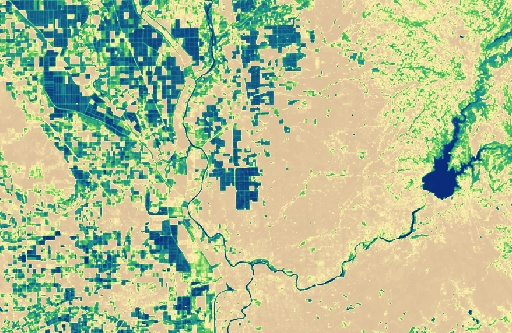

In [9]:
Image(url=ee.Image(et_daily_coll.select(['et']).sum()) \
        .reproject(crs=study_crs, scale=100) \
        .getThumbURL({'min': 0.0, 'max': 300, 'palette': ','.join(et_palette), 
                      'region': study_region}),
      embed=True, format='png') 

## Monthly ET (for one month)

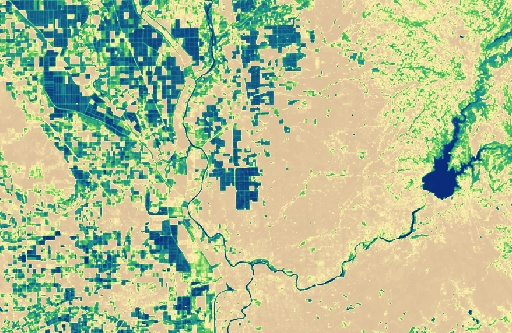

In [10]:
Image(url=ee.Image(et_monthly_coll.select(['et']).sum()) \
        .reproject(crs=study_crs, scale=100) \
        .getThumbURL({'min': 0.0, 'max': 300, 'palette': ','.join(et_palette), 
                      'region': study_region}),
      embed=True, format='png') 

## Monthly ETr (for one month)

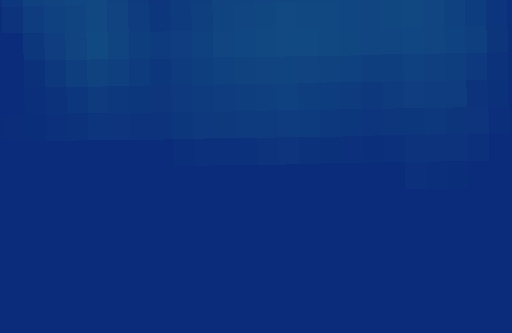

In [11]:
Image(url=ee.Image(et_monthly_coll.select(['etr']).sum()) \
        .reproject(crs=study_crs, scale=100) \
        .getThumbURL({'min': 0.0, 'max': 300, 'palette': ','.join(et_palette), 
                      'region': study_region}),
      embed=True, format='png') 